In [1]:
!pip install \
    surprise==0.1 \
    numpy==1.20.0 \
    scikit-learn==0.24

     |████████████████████████████████| 7.2 MB 11.1 MB/s 
  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached scikit-surprise-1.1.1.tar.gz (11.8 MB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-macosx_10_15_x86_64.whl size=780844 sha256=671b812cce243acafd90f7c98c4b3f7340b19e88261a2299cb25cb7e2582f643
  Stored in directory: /Users/vldpro/Library/Caches/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
You should consider upgrading via the '/Users/vldpro/Workspace/university/recsys/.venv/bin/python -m pip install --upgrade pip' command.


### Helper functions, constants and imports
---



In [ ]:
%matplotlib inlinexcode-select --install


In [ ]:
import random
import functools

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
from sklearn.model_selection import KFold
from surprise import Dataset, Reader, SVD, accuracy, KNNBasic
from surprise.model_selection import cross_validate, train_test_split

In [ ]:
sns.set_theme(rc={"figure.figsize": (13, 10), "figure.dpi": 400})

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

A seed for reproducibility

In [ ]:
SEED = 814526

Notebook parameters

In [ ]:
N_ITEMS = 500
N_USERS = 2000

### Generate user and item datasets

---



A function for generating a datset with `n_rows` entries and `n_feat` features, each with value from 0 to 100

In [ ]:
def generate_random_df(*, n_rows, n_feat=4):
  np.random.seed(SEED)
  array = np.random.randint(0, 100, size=(n_rows, n_feat))
  df = pd.DataFrame(array, columns=[f"attr_{i}" for i in range(n_feat)])
  return df

In [ ]:
items_df = generate_random_df(n_rows=500)
users_df = generate_random_df(n_rows=2000)

Next, we need to make a rating matrix from the generated dataframes in order to feed it to recommendation models from `surprise` library. This function takes 2 dataframes, applies some vectorized function on them and round the value to the range [0, 5]. The default function is `cosine_similarity`

In [ ]:
def generate_rating_matrix(*, user_df, item_df, rating_scale=5, rating_function=pairwise.cosine_similarity):
  sim_matrix = rating_function(user_df, item_df)
  rating_matrix = (sim_matrix * 5).round()
  return rating_matrix

In [ ]:
rating_matrix = generate_rating_matrix(user_df=users_df, item_df=items_df)
rating_matrix

array([[5., 4., 4., ..., 4., 5., 3.],
       [4., 5., 4., ..., 5., 4., 3.],
       [4., 4., 5., ..., 4., 4., 5.],
       ...,
       [2., 4., 4., ..., 4., 4., 3.],
       [4., 5., 5., ..., 5., 5., 4.],
       [4., 4., 5., ..., 4., 5., 4.]])

Now we transform the matrix to the long table format - where each row contains the tuple `(user_id, item_id, rating)`.

In [ ]:
def rating_matrix_to_long_table(rating_matrix):
  df = pd.DataFrame(rating_matrix)
  df["user_id"] = df.index
  return df.melt(id_vars=["user_id"], var_name="item_id", value_name="rating")


Thus we have `N_USERS x N_ITEMS` table with generated rating.

In [ ]:
full_rating_df = rating_matrix_to_long_table(rating_matrix)
full_rating_df

,user_id,item_id,rating
0,0,0,5.0
1,1,0,4.0
2,2,0,4.0
3,3,0,3.0
4,4,0,5.0
...,...,...,...
999995,1995,499,4.0
999996,1996,499,3.0
999997,1997,499,3.0
999998,1998,499,4.0


### Make dataset with custom distribution of ratings

---

A random sample with 5% of available data

In [ ]:
np.random.seed(SEED)
rating_sample_df = full_rating_df.sample(50000)
_rating_dist_df = rating_sample_df.groupby("item_id").count()

In [ ]:
_rating_dist_df

,user_id,rating
item_id,,
0,103,103
1,112,112
2,96,96
3,104,104
4,101,101
...,...,...
495,101,101
496,107,107
497,95,95


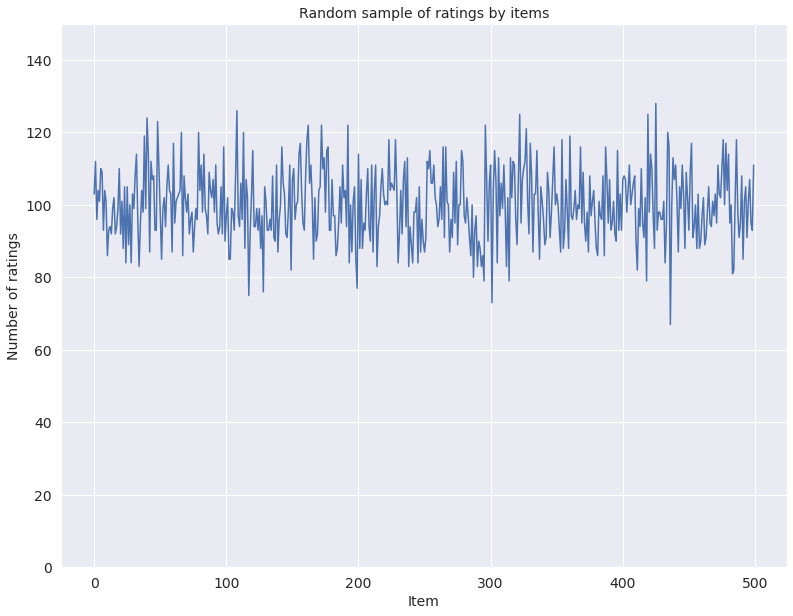

In [ ]:
_, ax = plt.subplots()
ax.set_title("Random sample of ratings by items")
ax.set_xlabel("Item")
ax.set_ylabel("Number of ratings")
ax.set_ylim(bottom=0, top=150)
sns.lineplot(data=_rating_dist_df, x=np.arange(0, len(_rating_dist_df)), ax=ax, y="rating")

Now we want to generate a sample with exponential distribution of rating. This function takes the dataframe and scale parameter of exp distribution and generates the sample.

In [ ]:
def get_exponential_sample_from_ratings_df(*, ratings_df, exp_scale):
  np.random.seed(SEED)
  exp_sample = pd.DataFrame(columns=ratings_df.columns)
  n_items = ratings_df["item_id"].nunique()
  for i in range(n_items):
    n_ratings = np.random.exponential(scale=exp_scale)
    sample = ratings_df[ratings_df["item_id"] == i].sample(int(n_ratings))
    exp_sample = pd.concat([exp_sample, sample], ignore_index=True)
  return exp_sample

In [ ]:
def _get_exp_distribution_df():
  exp_rating_df = get_exponential_sample_from_ratings_df(ratings_df=full_rating_df, exp_scale=100)
  return exp_rating_df.groupby("item_id").count()

_exp_rating_dist = _get_exp_distribution_df()

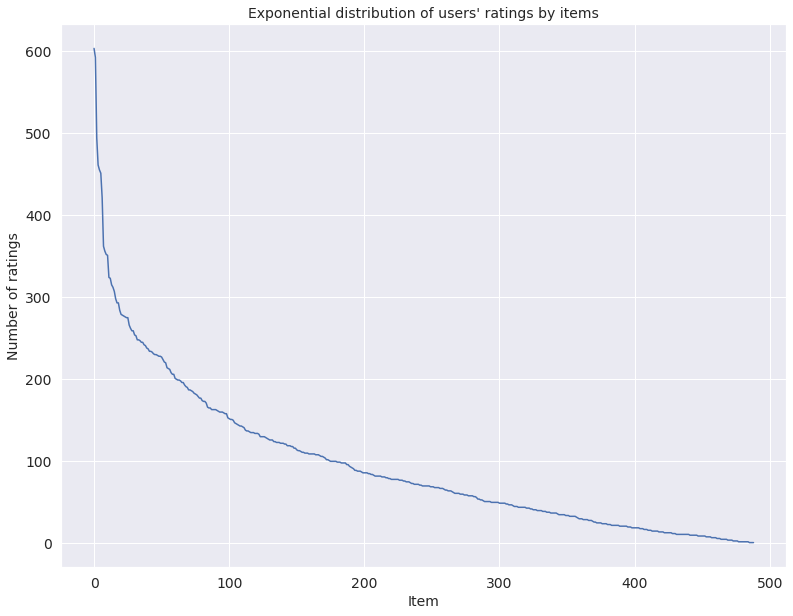

In [ ]:
_, ax = plt.subplots()
ax.set_title("Exponential distribution of users' ratings by items")
ax.set_xlabel("Item")
ax.set_ylabel("Number of ratings")
#sns.histplot(data=_exp_rating_dist, x="item_id", kde=True, ax=ax, bins=100)
_sorted_ratings = _exp_rating_dist.sort_values(by=["rating"], ascending=False)
sns.lineplot(data=_sorted_ratings, x=np.arange(0, len(_sorted_ratings)), ax=ax, y="rating")

In [ ]:
def samples(*, rating_df, n_samples):
  df_size = len(rating_df)
  for i in range(1, n_samples + 1):
    yield rating_df.sample(int(df_size / n_samples * i))

## Experiments

### Experiment: Noisy rating function (Work-In-Progress)

---



In [ ]:
def svd_train(df, cv=5):
  dataset = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  algo = SVD()
  return cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=cv, verbose=True)
  

In [ ]:
def knn_train(df, cv=5):
  dataset = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  algo = KNNBasic()
  return cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=cv, verbose=True)

A custom response function which generates responses based on similarity between `user_vec` and `item_vec` (can be vectors of vectors) and noise parameter `t` in range [0, 1]. The function is analytically defined as:

$f(U, I, t) = t \cdot sim(U, I) + (1 - t) \cdot r$

Where `r` is random component in range [-1, 1]

In [ ]:
def noisy_similarity_rating(user_vec, item_vec, t = 1):
  r = 2 * random.random() - 1
  return t * pairwise.cosine_similarity(user_vec, item_vec) + (1 - t) * r

We define a function for generation user responses with some noise which as defined by `t` parameter in `rating_function`. We generate 20 samples variying `t` parameter from 1 to 0  with step 0.05.

In [ ]:
def generate_noisy_samples(rating_function):
  rating_matrices = [
    generate_rating_matrix(
        user_df=users_df,
        item_df=items_df,
        rating_function=functools.partial(rating_function, t=t)
    ) for t in np.arange(1, 0, -0.05)
  ]

  rating_dfs = [
    rating_matrix_to_long_table(m) for m in rating_matrices
  ]

  samples = [
    df.sample(150_000) for df in rating_dfs
  ]
  return samples

In [ ]:
def train_model(train_fn, df_list):
  results = [train_fn(df) for df in df_list]
  return results

Next we train the **SVD** model on the generated samples.

**TODO**:
- Explore the similarity between samples

In [ ]:
np.random.seed(SEED)
random.seed(SEED)

_svd_results = train_model(
    svd_train,
    generate_noisy_samples(rating_function=noisy_similarity_rating)
)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4415  0.4346  0.4250  0.4286  0.4353  0.4330  0.0057  
MAE (testset)     0.3590  0.3535  0.3469  0.3490  0.3552  0.3527  0.0043  
Fit time          7.45    7.50    7.51    7.50    7.56    7.50    0.04    
Test time         0.25    0.23    0.23    0.44    0.24    0.28    0.08    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4588  0.4594  0.4489  0.4646  0.4561  0.4576  0.0051  
MAE (testset)     0.3602  0.3608  0.3529  0.3641  0.3581  0.3592  0.0037  
Fit time          7.44    7.52    7.54    7.52    7.55    7.51    0.04    
Test time         0.45    0.22    0.22    0.43    0.23    0.31    0.11    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset

### Experiment: relation between MAE/RMSE and sample size

---

We define 2 helper function, the first will train the model on multiple samples with size variying from 10 to 100 % of initial sample size.

In [ ]:
def evaluate_the_model_on_multiple_samples(train_fn, df, n_samples):
  results = []
  for rating_sample in samples(rating_df=df, n_samples=n_samples):
    result = train_fn(rating_sample, cv=2)
    results.append(result)
  return results

The second one extracts **MAE** and **RMSE** from evaluation results and make a DataFrame for easier vizualization.

In [ ]:
def evaluate_on_multiple_samples(df, train_fn, n_samples):
  results = evaluate_the_model_on_multiple_samples(train_fn, df, n_samples)

  df_dict = {
      "MAE": [],
      "RMSE": [],
      "Test time": [],
      "Fit time": []
  }

  for res in results:
    df_dict["MAE"].append(np.mean(res["test_mae"]))
    df_dict["RMSE"].append(np.mean(res["test_rmse"]))
    df_dict["Fit time"].append(np.mean(res["fit_time"]))
    df_dict["Test time"].append(np.mean(res["test_time"]))

  df_dict["Sample size"] = np.arange(10, 101, 10)
  return pd.DataFrame(df_dict)

Next we evaluate **SVD** and **KNN** algorithms

In [ ]:
np.random.seed(SEED)
_svd_results = evaluate_on_multiple_samples(full_rating_df, svd_train, n_samples=10)
_svd_results

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.7168  0.7174  0.7171  0.0003  
MAE (testset)     0.5663  0.5693  0.5678  0.0015  
Fit time          3.19    3.24    3.21    0.02    
Test time         0.70    0.42    0.56    0.14    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.5271  0.5328  0.5299  0.0028  
MAE (testset)     0.4217  0.4264  0.4240  0.0023  
Fit time          6.52    6.51    6.51    0.00    
Test time         1.11    0.96    1.04    0.07    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3485  0.3471  0.3478  0.0007  
MAE (testset)     0.2928  0.2915  0.2921  0.0006  
Fit time          9.85    9.94    9.89    0.04    
Test time         1.56    1.71    1.64    0.08    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  F

,MAE,RMSE,Test time,Fit time,Sample size
0,0.567779,0.717096,0.559165,3.210653,10
1,0.424030,0.529910,1.035854,6.512970,20
2,0.292135,0.347813,1.636439,9.894275,30
3,0.270949,0.317120,2.060898,13.236589,40
4,0.265679,0.309189,2.820393,16.805928,50
5,0.262739,0.305318,3.442992,20.090049,60
6,0.261188,0.303073,4.026603,23.542403,70
7,0.259886,0.301406,4.722342,26.957048,80
8,0.258443,0.299829,5.295197,30.677535,90
9,0.257632,0.298747,6.022761,33.958388,100


In [ ]:
_knn_results = evaluate_on_multiple_samples(full_rating_df, knn_train, n_samples=10)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.7074  0.7111  0.7092  0.0019  
MAE (testset)     0.5551  0.5600  0.5575  0.0025  
Fit time          0.44    0.44    0.44    0.00    
Test time         9.62    9.79    9.70    0.08    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.5669  0.5632  0.5651  0.0018  
MAE (testset)     0.4447  0.4404  0.4426  0.0022  
Fit time          1.36    1.31    1.34    0.02    
Test time         30.87   30.53   30.70   0.17    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computi

Further, we reformat the results obtained in order to create a single dataset with all the results.



In [ ]:
def _reformat_data(results):
  rmse_df = results.drop(columns=["MAE"])
  mae_df = results.drop(columns=["RMSE"])
  rmse_df = rmse_df.rename(columns={"RMSE": "Error"})
  mae_df = mae_df.rename(columns={"MAE": "Error"})
  rmse_df["Kind"] = "RMSE"
  mae_df["Kind"] = "MAE"
  return pd.concat([mae_df, rmse_df])

In [ ]:
_knn_reformated_results = _reformat_data(_knn_results)

_knn_reformated_results["Algo"] = "KNN"
_reformated["Algo"] = "SVD"
_knn_svd_results = pd.concat([_knn_reformated_results, _reformated])

In [ ]:
_knn_svd_results

In [ ]:
_svd_reformated = _reformat_data(_results)

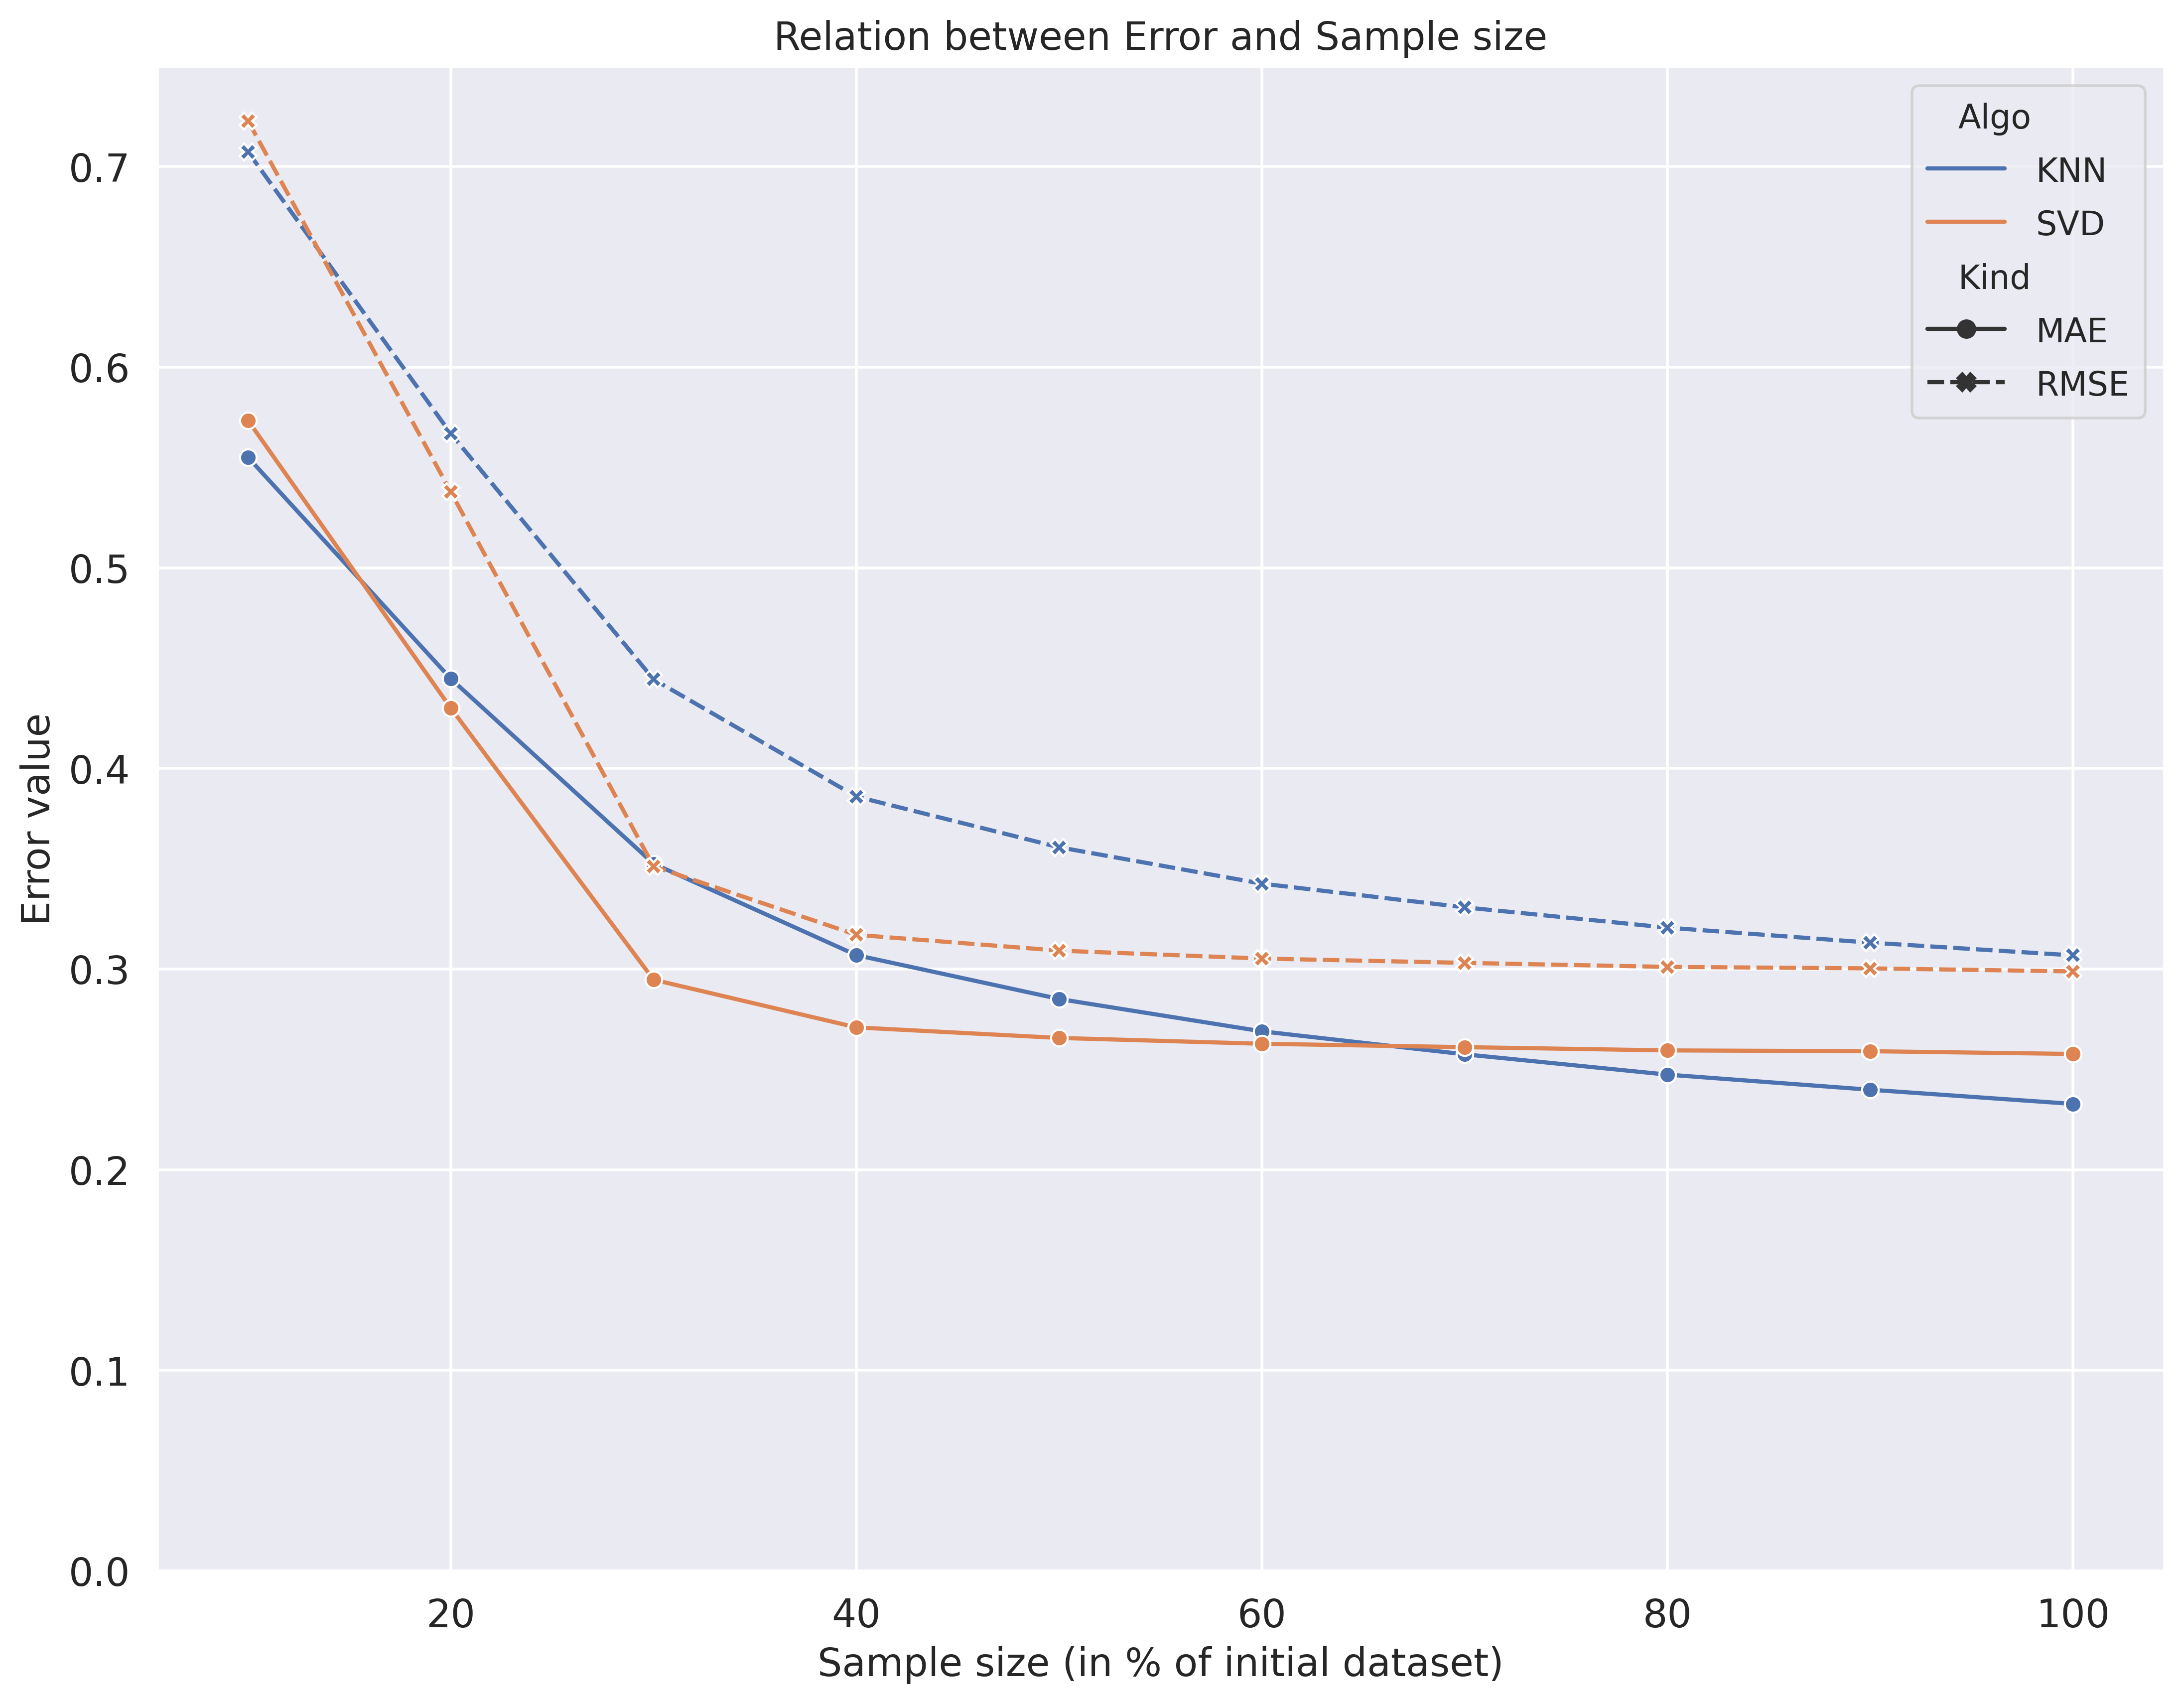

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Relation between Error and Sample size")
ax.set_xlabel("Sample size (in % of initial dataset)")
ax.set_ylabel("Error value")
ax.set_ylim(bottom=0, top=0.75)
sns.lineplot(
    x=_knn_svd_results["Sample size"],
    y=_knn_svd_results["Error"],
    style=_knn_svd_results["Kind"],
    hue=_knn_svd_results["Algo"],
    markers=True
)

Next we make a visualization for training time - sample size relation

In [ ]:
_knn_train_time = [
  9.62,
  30.87,
  61.07,
  107.22,
  161.60,
  228.33,
  306.47,
  392.65,
  502.85,
  611.64,
]

_knn_fit_time = [
  0.44,
  1.26,
  2.40,
  4.27,
  6.04,
  8.14,
  12.0,
  15.15,
  21.31,
  28.52,
]

In [ ]:
_svd_results

,MAE,RMSE,Test time,Fit time,Sample size
0,0.567779,0.717096,0.559165,3.210653,10
1,0.424030,0.529910,1.035854,6.512970,20
2,0.292135,0.347813,1.636439,9.894275,30
3,0.270949,0.317120,2.060898,13.236589,40
4,0.265679,0.309189,2.820393,16.805928,50
5,0.262739,0.305318,3.442992,20.090049,60
6,0.261188,0.303073,4.026603,23.542403,70
7,0.259886,0.301406,4.722342,26.957048,80
8,0.258443,0.299829,5.295197,30.677535,90
9,0.257632,0.298747,6.022761,33.958388,100


In [ ]:
_knn_tmp = _knn_results.copy()

In [ ]:
_knn_tmp["Test time"] = _knn_train_time
_knn_tmp["Fit time"] = _knn_fit_time

In [ ]:
_knn_time = _knn_tmp[["Test time", "Fit time", "Sample size"]].copy()
_knn_time["Algo"] = "KNN"
_svd_time = _svd_results[["Test time", "Fit time", "Sample size"]].copy()
_svd_time["Algo"] = "SVD"
_svd_knn_time = pd.concat([_svd_time, _knn_time])
_svd_knn_time

,Test time,Fit time,Sample size,Algo
0,0.559165,3.210653,10,SVD
1,1.035854,6.512970,20,SVD
2,1.636439,9.894275,30,SVD
3,2.060898,13.236589,40,SVD
4,2.820393,16.805928,50,SVD
5,3.442992,20.090049,60,SVD
6,4.026603,23.542403,70,SVD
7,4.722342,26.957048,80,SVD
8,5.295197,30.677535,90,SVD
9,6.022761,33.958388,100,SVD


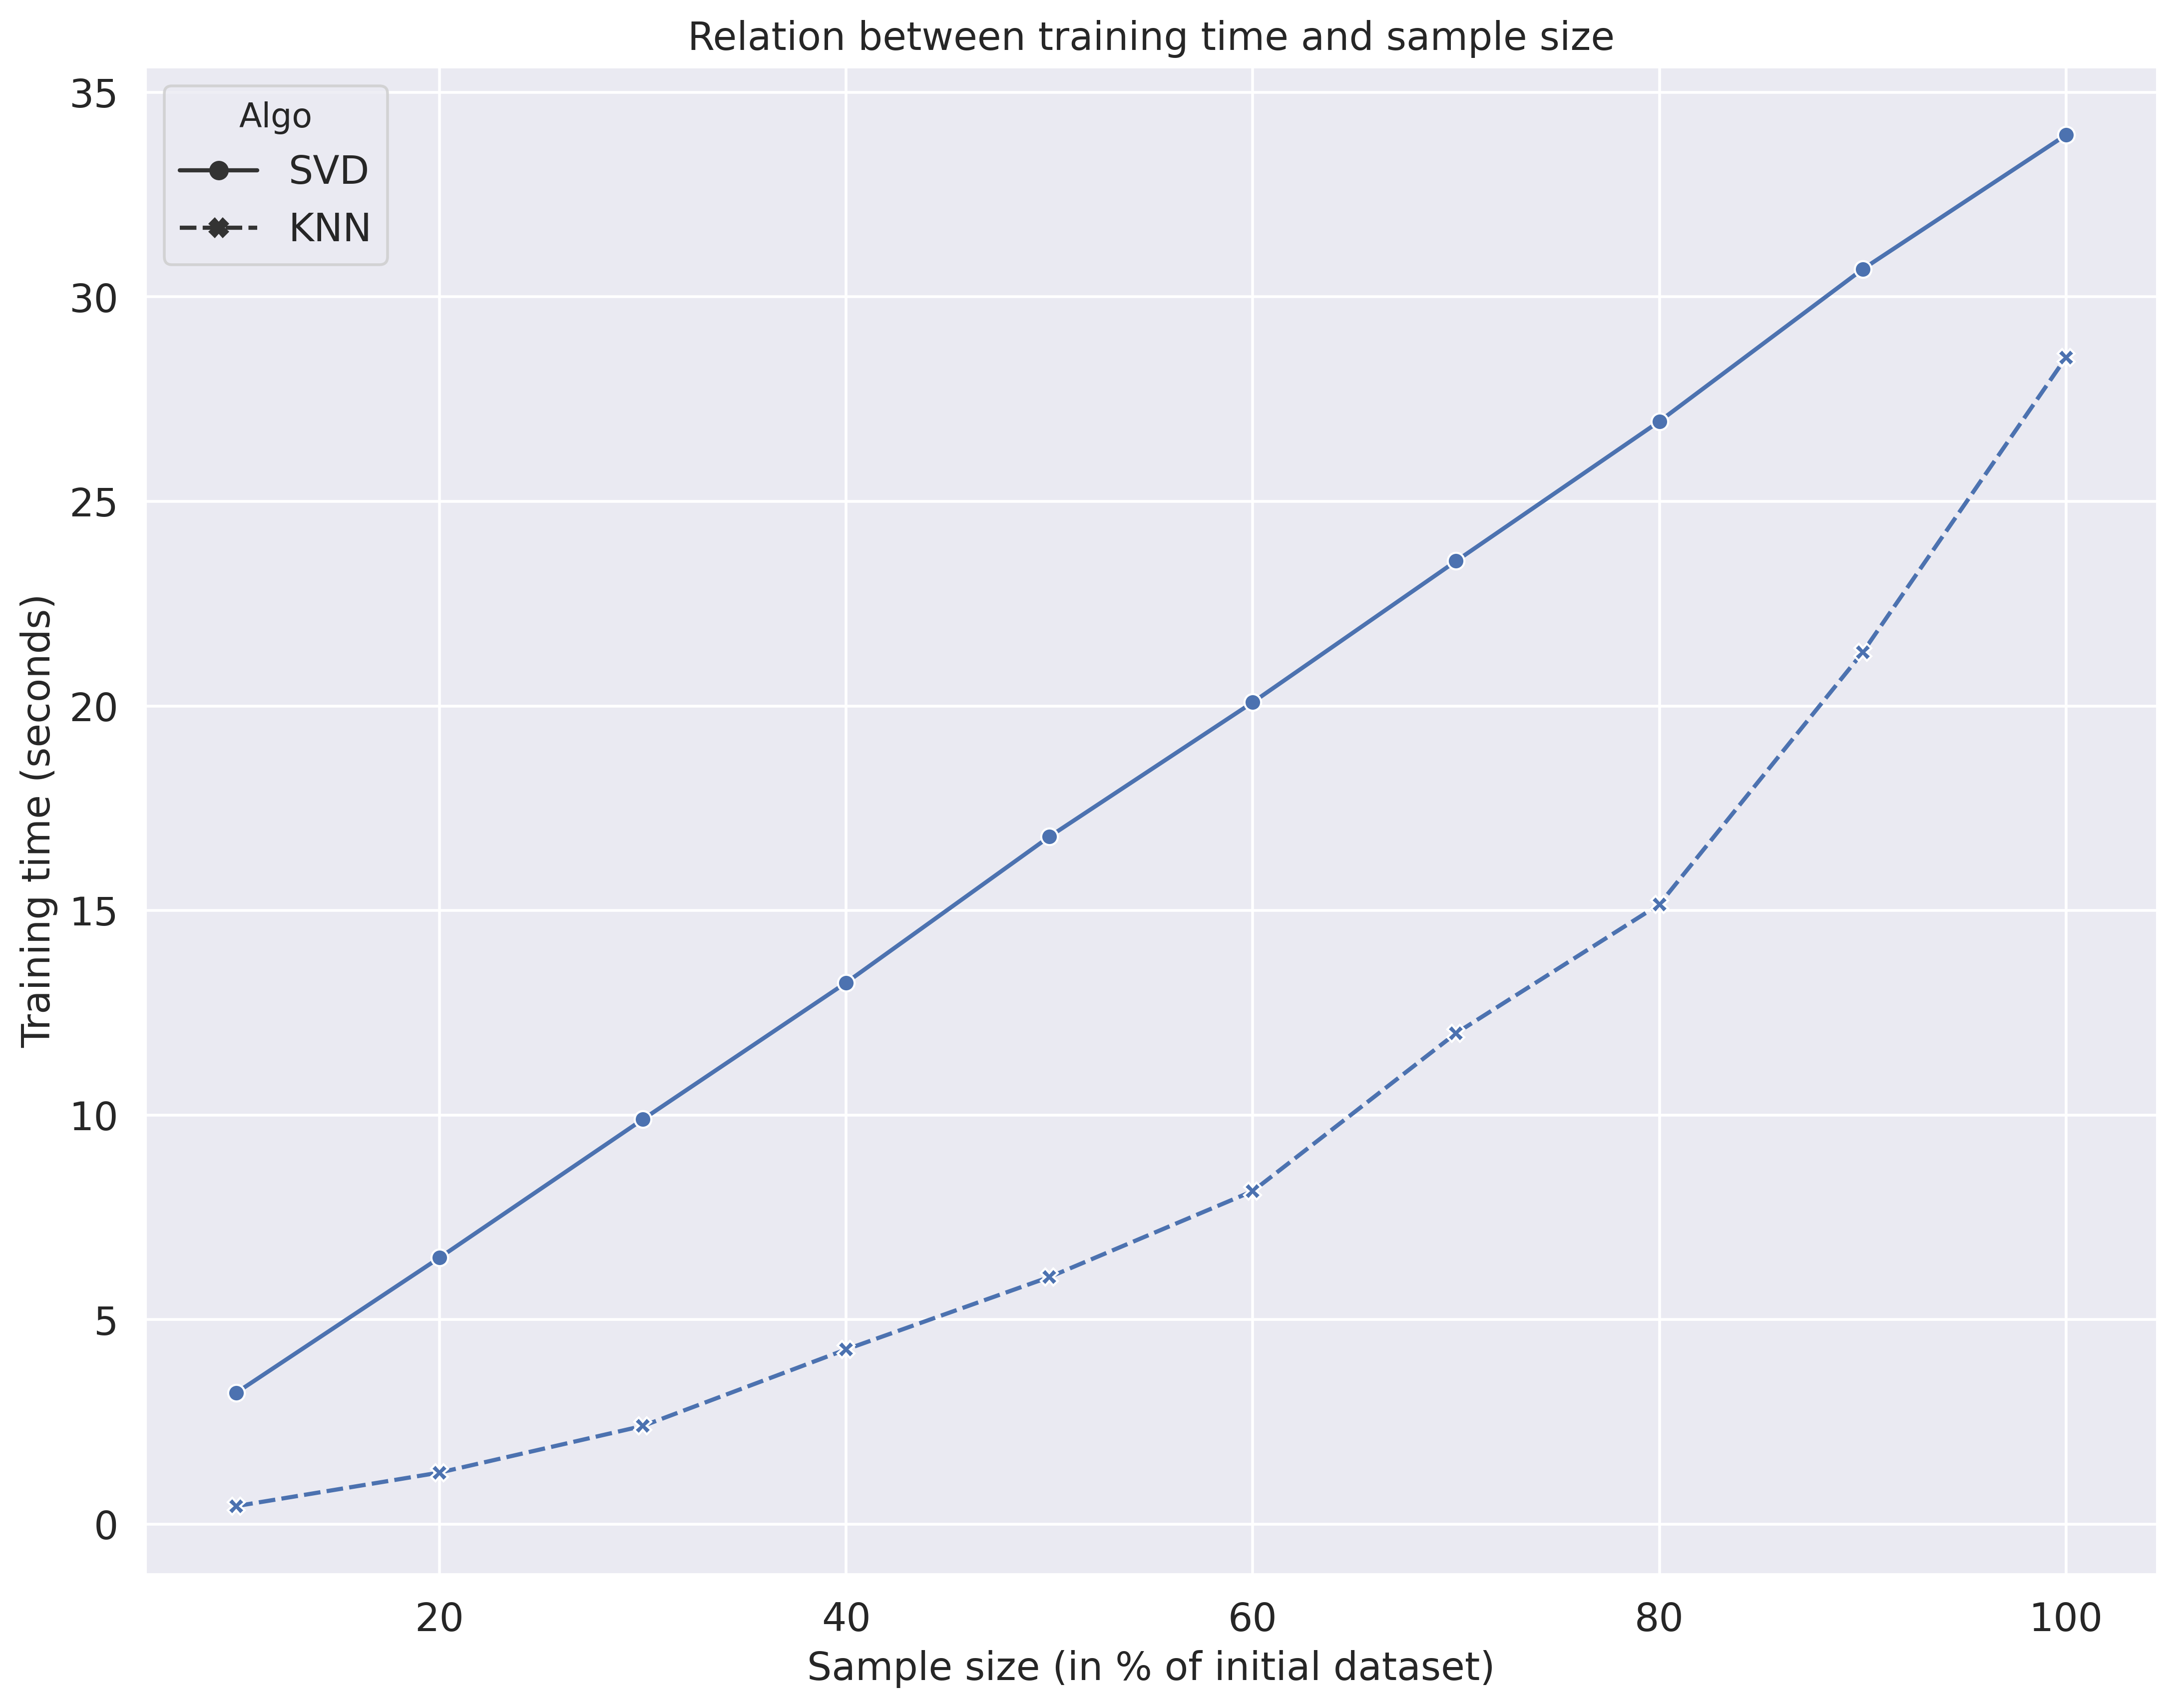

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Relation between training time and sample size")
ax.set_xlabel("Sample size (in % of initial dataset)")
ax.set_ylabel("Training time (seconds)")
sns.lineplot(
    x=_svd_knn_time["Sample size"],
    y=_svd_knn_time["Fit time"],
    style=_svd_knn_time["Algo"],
    markers=True,
    ax=ax
)

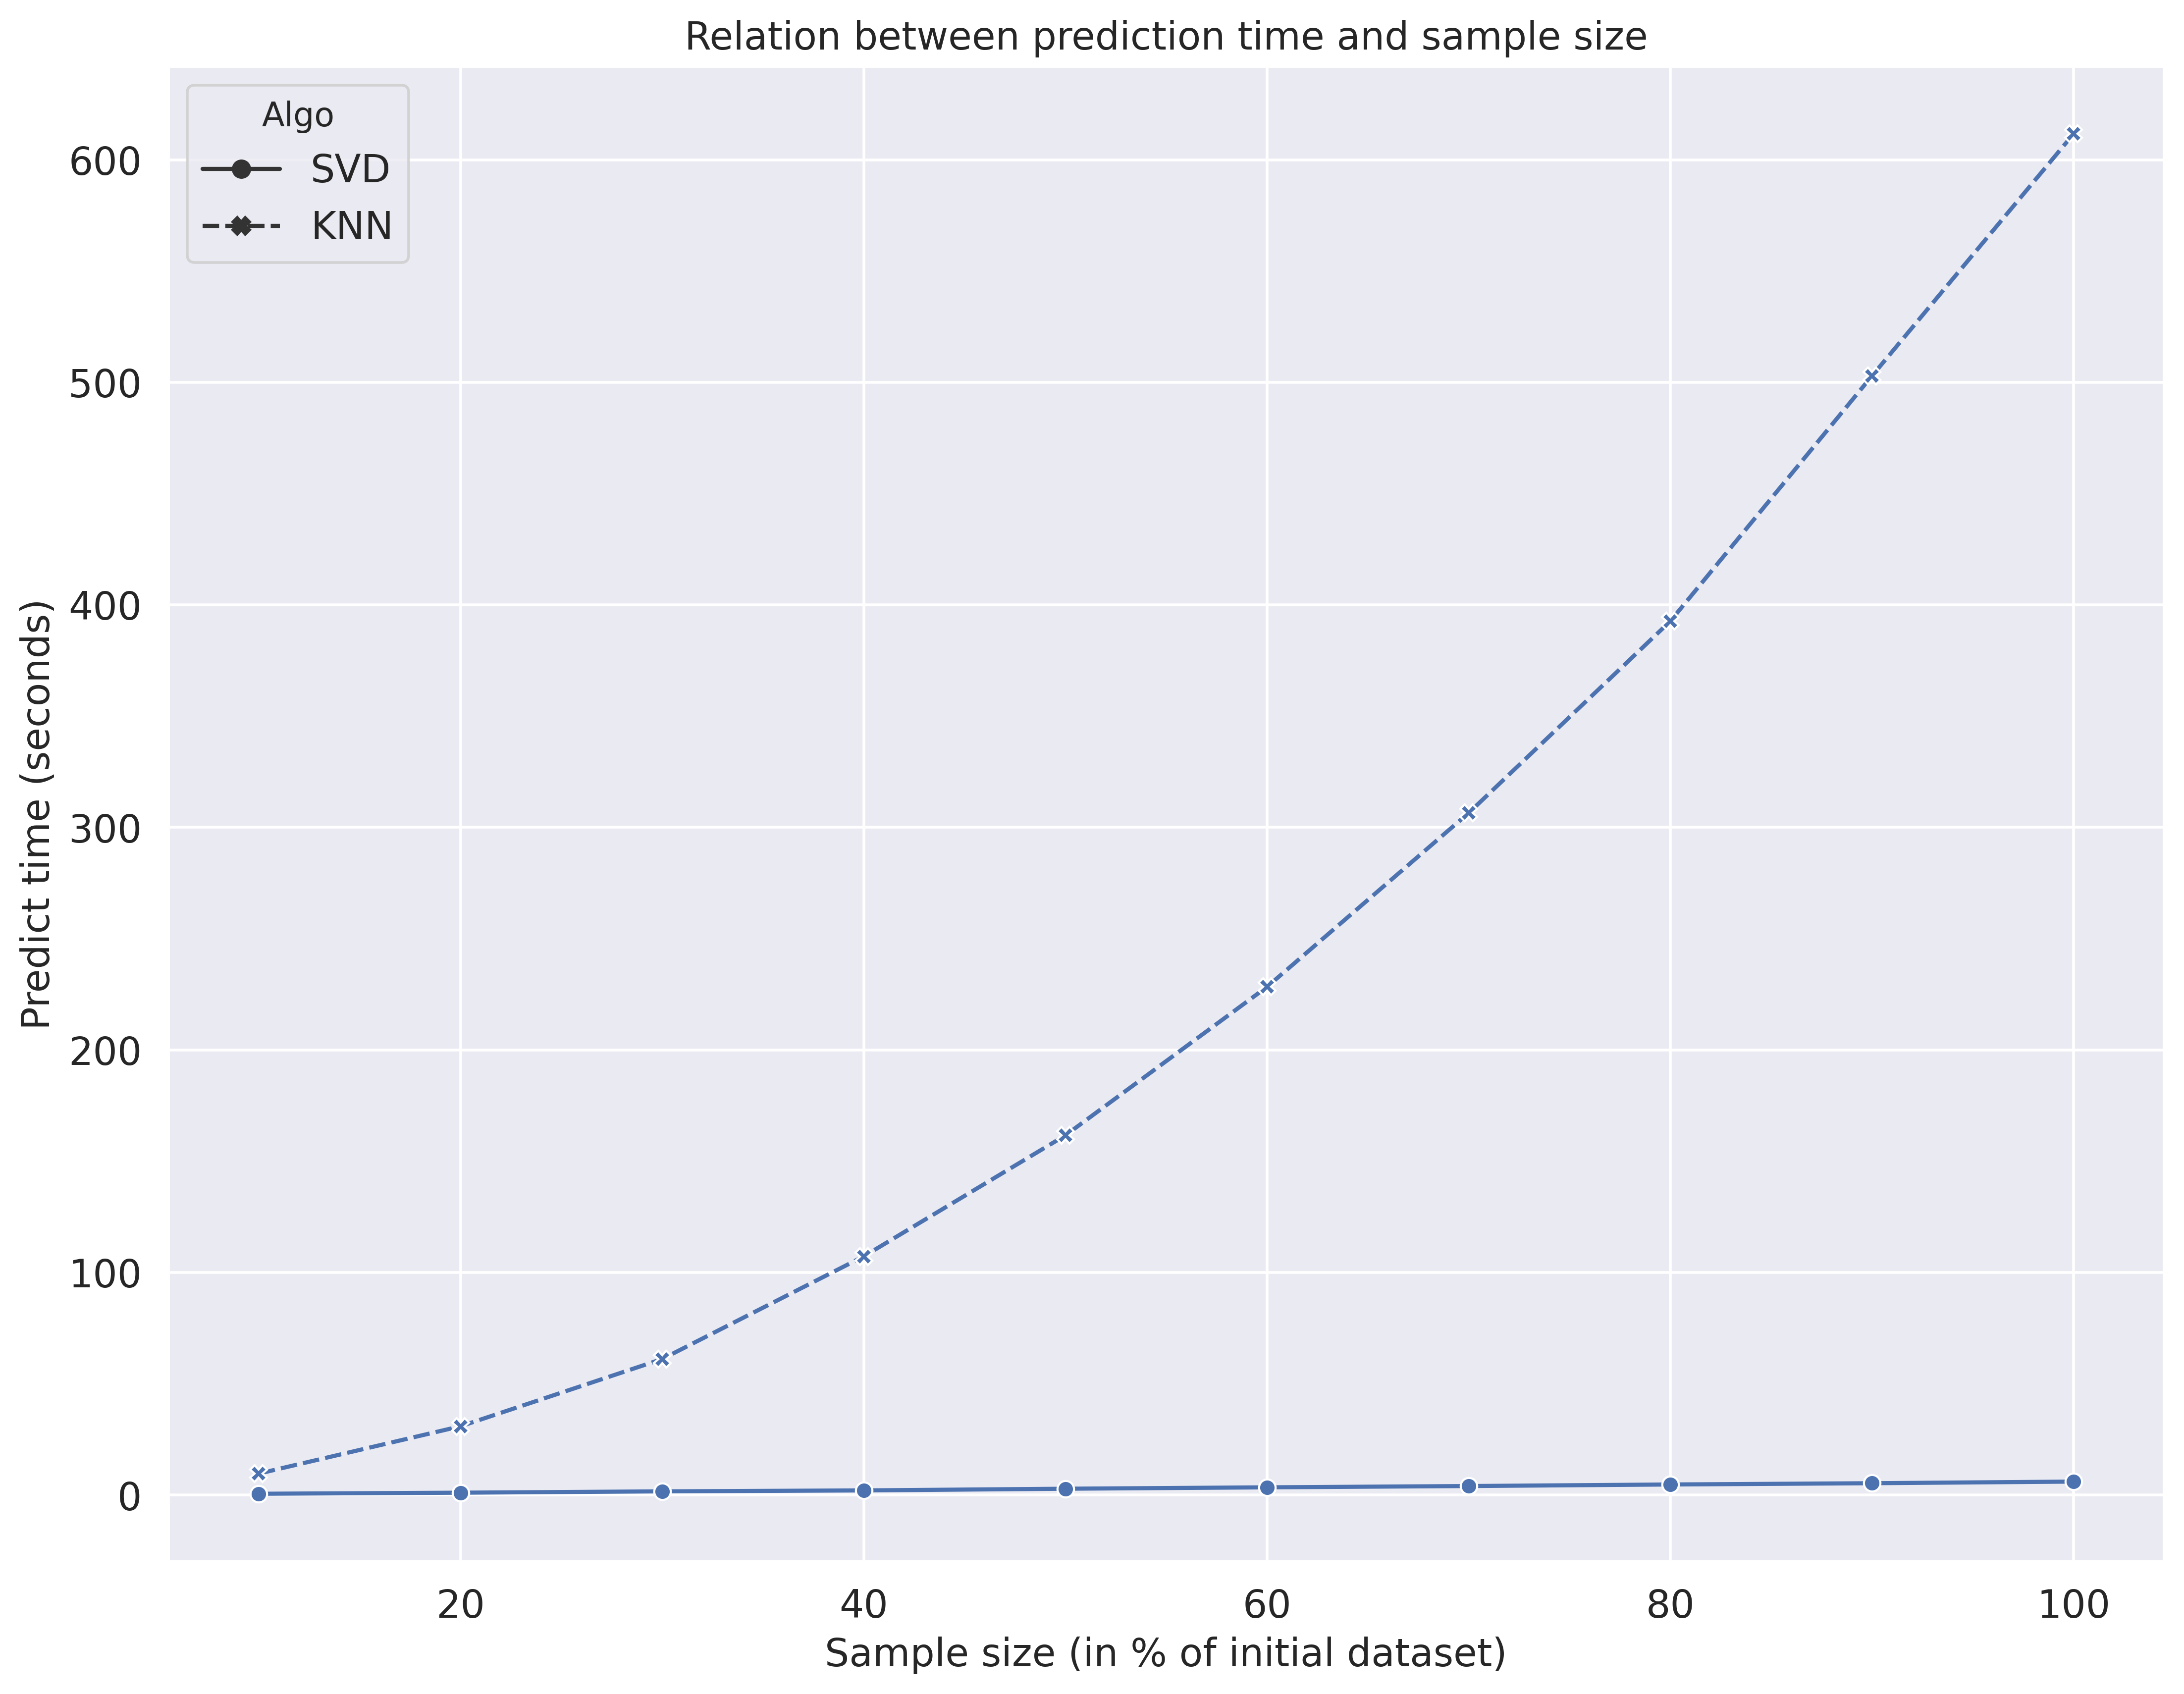

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Relation between prediction time and sample size")
ax.set_xlabel("Sample size (in % of initial dataset)")
ax.set_ylabel("Predict time (seconds)")
sns.lineplot(
    x=_svd_knn_time["Sample size"],
    y=_svd_knn_time["Test time"],
    style=_svd_knn_time["Algo"],
    markers=True,
    ax=ax
)

### Experiment: relation between sample size and training time

---



### SVD

With normally distributed ratings

In [ ]:
algo = SVD()
cross_validate(algo, surp_normal_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7399  0.7494  0.7544  0.7453  0.7479  0.7474  0.0048  
MAE (testset)     0.5846  0.5948  0.5939  0.5867  0.5917  0.5903  0.0040  
Fit time          2.42    2.42    2.40    2.40    2.40    2.41    0.01    
Test time         0.07    0.07    0.07    0.07    0.07    0.07    0.00    


{'fit_time': (2.416093587875366,
  2.424466371536255,
  2.401695728302002,
  2.3973748683929443,
  2.401312828063965),
 'test_mae': array([0.58455916, 0.59481744, 0.59386181, 0.58673389, 0.59174331]),
 'test_rmse': array([0.73993019, 0.74940511, 0.75444941, 0.74533638, 0.74793703]),
 'test_time': (0.06775951385498047,
  0.06836676597595215,
  0.06949877738952637,
  0.06873345375061035,
  0.06981205940246582)}

With exponentially distributed ratings

In [ ]:
algo = SVD()
cross_validate(algo, surp_exp_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7223  0.7238  0.7209  0.7291  0.7217  0.7236  0.0029  
MAE (testset)     0.5711  0.5712  0.5678  0.5761  0.5700  0.5713  0.0027  
Fit time          2.38    2.40    2.41    2.40    2.38    2.39    0.01    
Test time         0.07    0.07    0.07    0.07    0.07    0.07    0.00    


{'fit_time': (2.3841793537139893,
  2.395214080810547,
  2.4132630825042725,
  2.396310806274414,
  2.383516550064087),
 'test_mae': array([0.57111431, 0.57118143, 0.56782242, 0.576148  , 0.5700241 ]),
 'test_rmse': array([0.72228488, 0.72377554, 0.72094066, 0.72908143, 0.72171471]),
 'test_time': (0.06815695762634277,
  0.06974506378173828,
  0.06769633293151855,
  0.06939101219177246,
  0.06750798225402832)}

#### MAE depending on dataset coverage

In [ ]:
cv_results = []

for rating_sample in samples(rating_df=full_rating_df, n_samples=10):
  algo = SVD()
  _dataset = Dataset.load_from_df(rating_sample[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  result = cross_validate(algo, _dataset, measures=['RMSE', 'MAE'], cv=2, verbose=True)
  cv_results.append(result)

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.7331  0.7297  0.7314  0.0017  
MAE (testset)     0.5785  0.5749  0.5767  0.0018  
Fit time          3.02    3.03    3.03    0.01    
Test time         0.36    0.35    0.35    0.00    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.5182  0.5483  0.5333  0.0150  
MAE (testset)     0.4148  0.4374  0.4261  0.0113  
Fit time          6.14    6.17    6.16    0.01    
Test time         0.74    0.72    0.73    0.01    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3470  0.3451  0.3460  0.0010  
MAE (testset)     0.2917  0.2904  0.2910  0.0007  
Fit time          9.38    9.45    9.42    0.04    
Test time         1.09    1.10    1.10    0.01    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  F

In [ ]:
_results = [res["test_mae"][0] for res in cv_results]
_results

[0.5784907726502801,
 0.41478014113642936,
 0.2916966021047805,
 0.27141063046797187,
 0.2661304678380038,
 0.26357424051670864,
 0.2616142222816303,
 0.26052345029827867,
 0.2593369681530534,
 0.258092427671419]

In [ ]:
_data = pd.DataFrame()
_data["MAE"] = _results
_data["Sample_Size"] = np.arange(10, 101, 10)

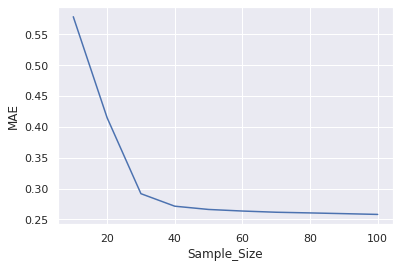

In [ ]:
sns.lineplot(data=_data, x="Sample_Size", y="MAE")

### KNN

In [ ]:
from surprise import KNNBasic


In [ ]:
knn_algo = KNNBasic(sim_options={"name": "cosine"})
cross_validate(knn_algo, surp_normal_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Computing the cosine similarity matrix...


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7957  0.7952  0.7996  0.8073  0.8015  0.7999  0.0044  
MAE (testset)     0.6292  0.6318  0.6314  0.6403  0.6329  0.6331  0.0038  
Fit time          2.03    1.61    1.64    1.59    1.63    1.70    0.17    
Test time         1.34    1.34    1.36    1.35    1.38    1.35    0.02    


{'fit_time': (2.033316135406494,
  1.6128532886505127,
  1.6398506164550781,
  1.5922119617462158,
  1.626539707183838),
 'test_mae': array([0.62917638, 0.6317954 , 0.63137438, 0.64026126, 0.63288927]),
 'test_rmse': array([0.79565065, 0.79520979, 0.79964635, 0.80730033, 0.8015056 ]),
 'test_time': (1.3403890132904053,
  1.336042881011963,
  1.3635547161102295,
  1.3521411418914795,
  1.3792345523834229)}

In [ ]:
knn_algo = KNNBasic(sim_options={"name": "cosine"})
cross_validate(knn_algo, surp_exp_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Computing the cosine similarity matrix...


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7798  0.7823  0.7858  0.7869  0.7789  0.7827  0.0032  
MAE (testset)     0.6177  0.6183  0.6202  0.6221  0.6137  0.6184  0.0028  
Fit time          2.22    2.26    2.20    2.25    2.18    2.22    0.03    
Test time         1.83    1.78    1.83    1.83    1.89    1.83    0.03    


{'fit_time': (2.2221519947052,
  2.2577805519104004,
  2.2044942378997803,
  2.2452409267425537,
  2.181037664413452),
 'test_mae': array([0.61769565, 0.61829295, 0.62022908, 0.62205028, 0.61367367]),
 'test_rmse': array([0.77984699, 0.78234265, 0.78575353, 0.78691772, 0.77887771]),
 'test_time': (1.8283109664916992,
  1.784238576889038,
  1.827542781829834,
  1.828648567199707,
  1.8873496055603027)}

#### MAE depending on dataset **coverage**

In [ ]:
cv_results = []

for rating_sample in samples(rating_df=full_rating_df, n_samples=10):
  algo = KNNBasic(sim_options={"name": "cosine"})
  _dataset = Dataset.load_from_df(rating_sample[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  result = cross_validate(algo, _dataset, measures=['RMSE', 'MAE'], cv=2, verbose=True)
  cv_results.append(result)

  

NameError: ignored

In [ ]:
cv_results

[{'fit_time': (2.269840955734253, 2.159127950668335),
  'test_mae': array([0.62179305, 0.62561192]),
  'test_rmse': array([0.78847913, 0.79356783]),
  'test_time': (7.762932777404785, 7.735900163650513)},
 {'fit_time': (3.6298372745513916, 3.904237747192383),
  'test_mae': array([0.52065037, 0.52209213]),
  'test_rmse': array([0.65940977, 0.66409166]),
  'test_time': (25.066633939743042, 25.276814460754395)},
 {'fit_time': (5.012295722961426, 5.168306827545166),
  'test_mae': array([0.40665386, 0.40235206]),
  'test_rmse': array([0.5171993 , 0.51017608]),
  'test_time': (51.20661997795105, 52.05418610572815)},
 {'fit_time': (6.94805121421814, 6.942681074142456),
  'test_mae': array([0.35345885, 0.35491719]),
  'test_rmse': array([0.45149127, 0.45385662]),
  'test_time': (90.68943810462952, 92.98332166671753)},
 {'fit_time': (8.91606068611145, 9.074350833892822),
  'test_mae': array([0.32672662, 0.3240964 ]),
  'test_rmse': array([0.42050452, 0.4164018 ]),
  'test_time': (129.5507130622

In [ ]:
_results = [res["test_mae"][0] for res in cv_results]
_results

_data = pd.DataFrame()
_data["MAE"] = _results
_data["Sample_Size"] = np.arange(10, 101, 10)

sns.lineplot(data=_data, x="Sample_Size", y="MAE")

NameError: ignored

## Calculations with noisy data (Draft)

In [ ]:
items_df = generate_random_df(n_rows=500)
users_df = generate_random_df(n_rows=2000)

rating_matrix = generate_rating_matrix(user_df=users_df, item_df=items_df, rating_function=rating_function)

In [ ]:
rating_matrices = [
  generate_rating_matrix(
      user_df=users_df,
      item_df=items_df,
      rating_function=functools.partial(rating_function, t=t)
  ) for t in np.arange(1, 0, -0.05)
]

In [ ]:
rating_dfs = [
    rating_matrix_to_long_table(m) for m in rating_matrices
]

In [ ]:
rating_samples_dfs = [
    df.sample(150_000) for df in rating_dfs
]

In [ ]:
def calculate_svd_results(samples):
  svd_results = []
  for rating_sample in samples:
    algo = SVD()
    _dataset = Dataset.load_from_df(rating_sample[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
    result = cross_validate(algo, _dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    svd_results.append(result)

In [ ]:
svd_results = calculate_svd_results(rating_samples_dfs)

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.6605  0.6581  0.6593  0.0012  
MAE (testset)     0.5235  0.5225  0.5230  0.0005  
Fit time          4.40    4.42    4.41    0.01    
Test time         0.62    0.72    0.67    0.05    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.6150  0.6164  0.6157  0.0007  
MAE (testset)     0.4792  0.4800  0.4796  0.0004  
Fit time          4.44    4.44    4.44    0.00    
Test time         0.63    0.62    0.63    0.00    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.6357  0.6310  0.6334  0.0023  
MAE (testset)     0.5057  0.5026  0.5042  0.0016  
Fit time          4.43    4.44    4.43    0.00    
Test time         0.72    0.62    0.67    0.05    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  F

KeyboardInterrupt: ignored

In [ ]:
np.arange(1, 0, -0.05)

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05])

In [ ]:
def calculate_sim_results(samples):
  results = []
  for sample in samples:
    kf = KFold(n_splits=5)
    rmse_list = []
    train_sample = sample.sample(20_000)

    _users = users_df.loc[train_sample["user_id"]]
    _items = items_df.loc[train_sample["item_id"]]

    _est_rating = np.around(pairwise.cosine_similarity(_users, _items) * 5)
    print(_est_rating)
    rmse = (_est_rating - train_sample["rating"]) ** 2
    rmse = np.sqrt(np.sum(rmse))
    rmse_list.append(rmse)
    print(rmse_list)
    result.append(rmse_list)
  return results


In [ ]:
calculate_sim_results(rating_samples_dfs)